In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


modules loaded


In [6]:
data_dir = '/kaggle/input/final-dataset/new-data'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    
    # Exclude files with certain names, e.g., '.DS_Store'
    if not os.path.isdir(foldpath):
        continue
    
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        # Exclude specific file names, adjust as needed
        if os.path.isfile(fpath) and not file.startswith('.'):
            filepaths.append(fpath)
            labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data_dir = pd.concat([Fseries, Lseries], axis= 1)

In [7]:
data_dir

,filepaths,labels
0,/kaggle/input/final-dataset/new-data/no-waterm...,no-watermark
1,/kaggle/input/final-dataset/new-data/no-waterm...,no-watermark
2,/kaggle/input/final-dataset/new-data/no-waterm...,no-watermark
3,/kaggle/input/final-dataset/new-data/no-waterm...,no-watermark
4,/kaggle/input/final-dataset/new-data/no-waterm...,no-watermark
...,...,...
5994,/kaggle/input/final-dataset/new-data/watermark...,watermark
5995,/kaggle/input/final-dataset/new-data/watermark...,watermark
5996,/kaggle/input/final-dataset/new-data/watermark...,watermark
5997,/kaggle/input/final-dataset/new-data/watermark...,watermark


In [8]:
# train dataframe
train_df, dummy_df = train_test_split(data_dir,  train_size= 0.7, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [9]:
# crobed image size
batch_size = 16
img_size = (240, 240)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4199 validated image filenames belonging to 2 classes.
Found 900 validated image filenames belonging to 2 classes.
Found 900 validated image filenames belonging to 2 classes.


In [10]:

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Create Model Structure
img_size = (240, 240)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer
from tensorflow.keras.applications import DenseNet201

base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-3),
    Dense(512, kernel_regularizer=regularizers.l2(l=0.01), activation='relu'),
    Dropout(rate=0.5, seed=123),
    BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-3),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.01), activation='relu'),
    Dropout(rate=0.5, seed=123),
    Dense(class_count, activation='sigmoid')
])
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

model.compile(Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

model.summary()

16705208/16705208 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                        

In [11]:
batch_size = 16   # set batch size for training
epochs =  30  # number of all epochs in training
history =  model.fit(x=train_gen, epochs=epochs, verbose=1, validation_data=valid_gen,
          validation_steps=None, shuffle=False, callbacks=[early_stopping])

Epoch 1/30


2024-01-11 20:52:07.073277: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


263/263 [==============================] - 83s 150ms/step - loss: 6.1315 - accuracy: 0.5246 - val_loss: 2.6028 - val_accuracy: 0.5056
Epoch 2/30
263/263 [==============================] - 37s 140ms/step - loss: 1.5916 - accuracy: 0.6390 - val_loss: 1.0759 - val_accuracy: 0.6378
Epoch 3/30
263/263 [==============================] - 37s 140ms/step - loss: 0.7759 - accuracy: 0.7740 - val_loss: 0.8397 - val_accuracy: 0.6822
Epoch 4/30
263/263 [==============================] - 37s 141ms/step - loss: 0.5565 - accuracy: 0.8100 - val_loss: 0.5293 - val_accuracy: 0.8256
Epoch 5/30
263/263 [==============================] - 37s 141ms/step - loss: 0.4878 - accuracy: 0.8316 - val_loss: 0.5917 - val_accuracy: 0.8089
Epoch 6/30
263/263 [==============================] - 37s 140ms/step - loss: 0.4543 - accuracy: 0.8442 - val_loss: 0.7966 - val_accuracy: 0.6600
Epoch 7/30
263/263 [==============================] - 37s 141ms/step - loss: 0.4305 - accuracy: 0.8464 - val_loss: 0.5137 - val_accuracy: 0.8

In [12]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

12/12 [==============================] - 1s 61ms/step - loss: 0.5107 - accuracy: 0.8333
Train Loss:  0.2988755702972412
Train Accuracy:  0.9010416865348816
--------------------
Validation Loss:  0.517003059387207
Validation Accuracy:  0.8072916865348816
--------------------
Test Loss:  0.5107298493385315
Test Accuracy:  0.8333333134651184


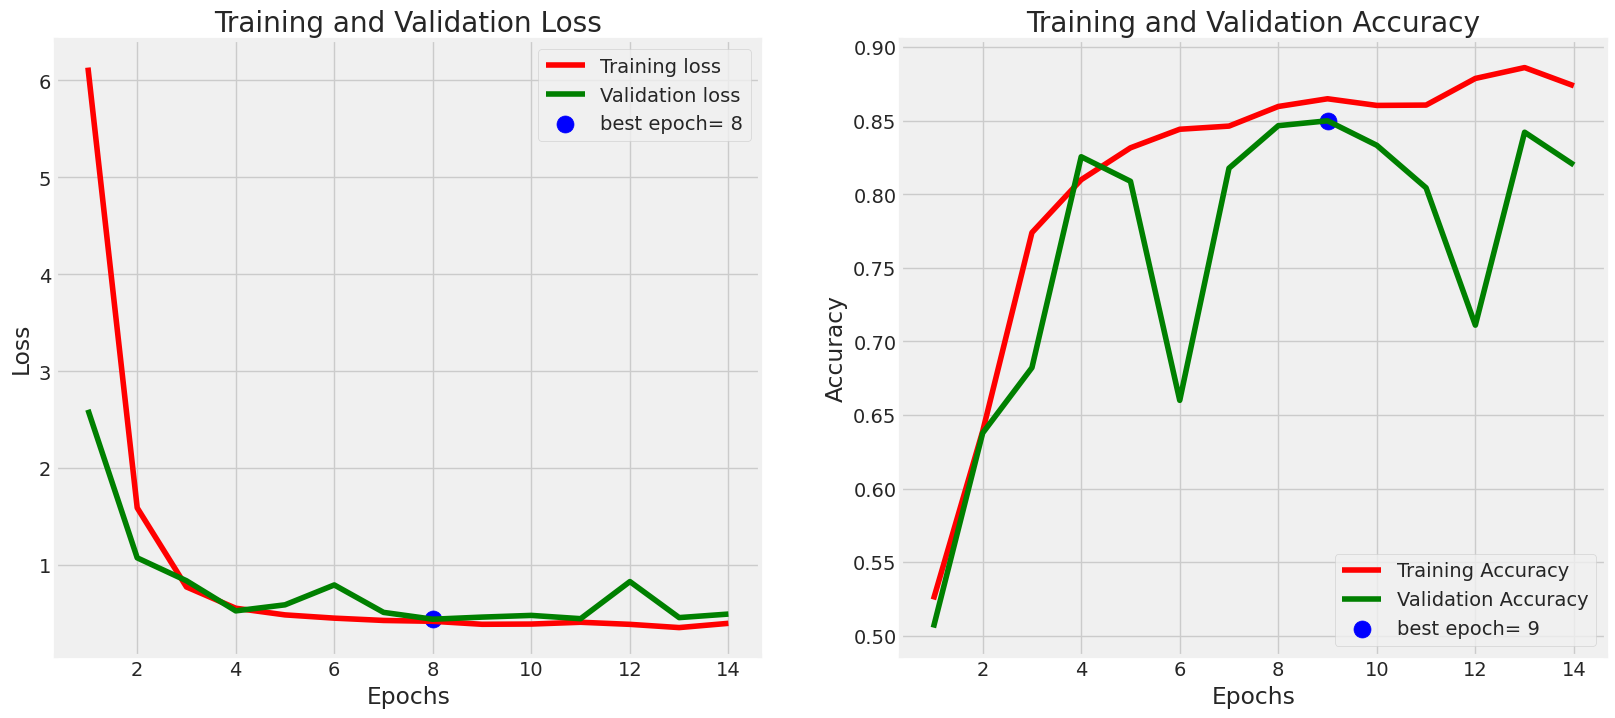

In [13]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

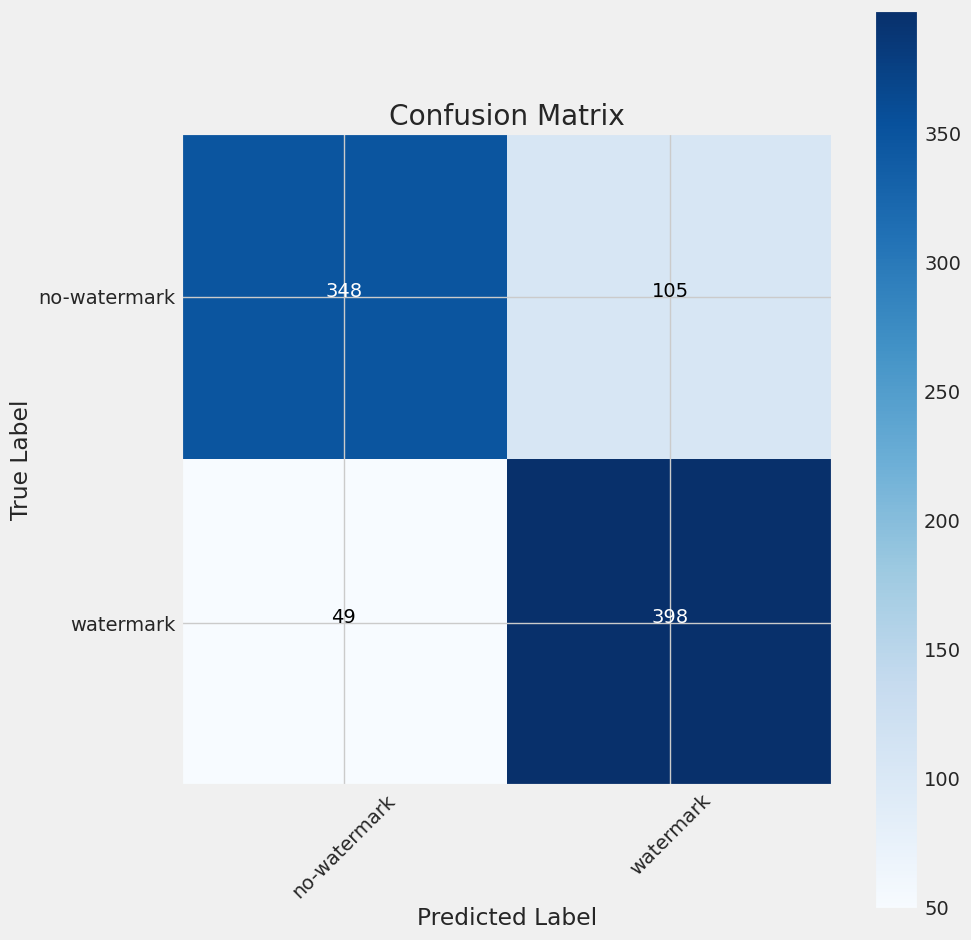

In [14]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [15]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

no-watermark       0.88      0.77      0.82       453
   watermark       0.79      0.89      0.84       447

    accuracy                           0.83       900
   macro avg       0.83      0.83      0.83       900
weighted avg       0.83      0.83      0.83       900



In [17]:
image_path = '/kaggle/input/final-dataset/new-data/no-watermark/File10.png'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((240, 240))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = model.predict(img_array)
class_labels = classes
score = tf.nn.sigmoid(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 37ms/step
no-watermark


In [18]:
image_path = '/kaggle/input/final-dataset/new-data/watermark/lsb1007.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((240, 240))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = model.predict(img_array)
class_labels = classes
score = tf.nn.sigmoid(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 25ms/step
watermark
